In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader, random_split
import os
import subprocess
import random
from tqdm import tqdm
from PIL import Image

## Importing images

In [2]:
class DentalImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.classes = sorted(set([img.split("_")[0] for img in self.image_paths]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label_str = img_name.split("_")[0]
        label = self.class_to_idx[label_str]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = DentalImageDataset("./Unzipped folder/Dataset", transform=transform)

num_classes = len(dataset.classes)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=80, shuffle=False, num_workers=4)

## Using GPU

In [4]:
def get_freest_gpu():
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits,noheader"],
        stdout=subprocess.PIPE, text=True
    )
    memory_free = [int(x) for x in result.stdout.strip().split('\n')]
    return f"cuda:{memory_free.index(max(memory_free))}" if torch.cuda.is_available() else "cpu"

device = torch.device(get_freest_gpu())
print(f"Using device: {device}")

Using device: cuda:6


## Model Architecture

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        return self.relu(out)

class ComplexCNNWithAttention(nn.Module):
    """Deep CNN with residual blocks and channel attention."""
    def __init__(self, num_classes):
        super(ComplexCNNWithAttention, self).__init__()
        # Initial layer
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # Residual layers
        self.layer1 = self._make_layer(64, 128, blocks=2, stride=1)
        self.layer2 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer3 = self._make_layer(256, 512, blocks=2, stride=2)
        # Channel attention
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1),
            nn.Sigmoid()
        )
        # Classification head
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # apply attention
        attn = self.attention(x)
        x = x * attn
        x = self.pool(x)
        x = self.classifier(x)
        return x

## Plot loss and accuracy

In [6]:
def plot_accuracy(history):
    # Accuracy
    plt.figure()
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    #plt.savefig(os.path.join(output_dir, 'accuracy.png'))
    #plt.close()
    return plt
def plot_loss(history):
    # Loss
    plt.figure()
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig(os.path.join(output_dir, 'loss.png'))
    #plt.close()
    return plt

## Model evaluation

In [7]:
def evaluate_model(model, loader, device, class_names):
    model.to(device).eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

## Training loop

In [8]:
def train_model(model, train_loader, val_loader, device, epochs, lr, wd):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))

    best_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    #os.makedirs(output_dir, exist_ok=True)

    for epoch in range(1, epochs + 1):
        # Train
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for imgs, labels in tqdm(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss, train_acc = running_loss/total, correct/total

        # Validate
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                v_loss += loss.item() * imgs.size(0)
                preds = outputs.argmax(dim=1)
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)
        val_loss, val_acc = v_loss/v_total, v_correct/v_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    #plot_history(history, output_dir)
    return history

In [9]:
model = ComplexCNNWithAttention(num_classes)
epochs = 5
lr = 1e-4
wd = 1e-5
history = train_model(model, train_loader, val_loader, device, epochs, lr, wd)

100%|██████████| 150/150 [01:28<00:00,  1.70it/s]


Epoch 1/5 | Train Loss: 1.1314, Acc: 0.5743 | Val Loss: 0.9717, Acc: 0.6343


100%|██████████| 150/150 [01:27<00:00,  1.70it/s]


Epoch 2/5 | Train Loss: 0.6629, Acc: 0.7454 | Val Loss: 0.7932, Acc: 0.6983


100%|██████████| 150/150 [01:28<00:00,  1.70it/s]


Epoch 3/5 | Train Loss: 0.5052, Acc: 0.8072 | Val Loss: 0.4043, Acc: 0.8420


100%|██████████| 150/150 [01:27<00:00,  1.70it/s]


Epoch 4/5 | Train Loss: 0.3733, Acc: 0.8565 | Val Loss: 0.3183, Acc: 0.8770


100%|██████████| 150/150 [01:28<00:00,  1.70it/s]


Epoch 5/5 | Train Loss: 0.3014, Acc: 0.8840 | Val Loss: 0.2895, Acc: 0.8863


## Accuracy and Loss curves

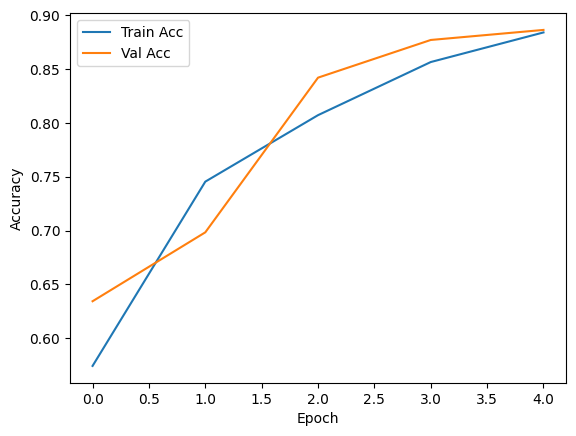

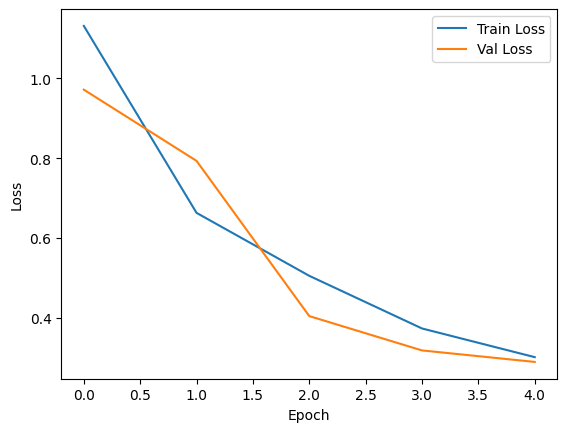

In [13]:
plot_accuracy(history).show()
plot_loss(history).show()

## Seeing the results

In [14]:
import random
import matplotlib.pyplot as plt

def show_predictions(model, dataset, device, idx_to_class, num_images=8):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)  # [1, C, H, W]
            output = model(input_tensor)
            _, pred = torch.max(output, 1)

            img = image.permute(1, 2, 0).cpu() * 0.5 + 0.5  # unnormalize

            plt.subplot(2, (num_images+1)//2, i+1)
            plt.imshow(img)
            plt.title(f"Actual: {idx_to_class[label]}\nPred: {idx_to_class[pred.item()]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

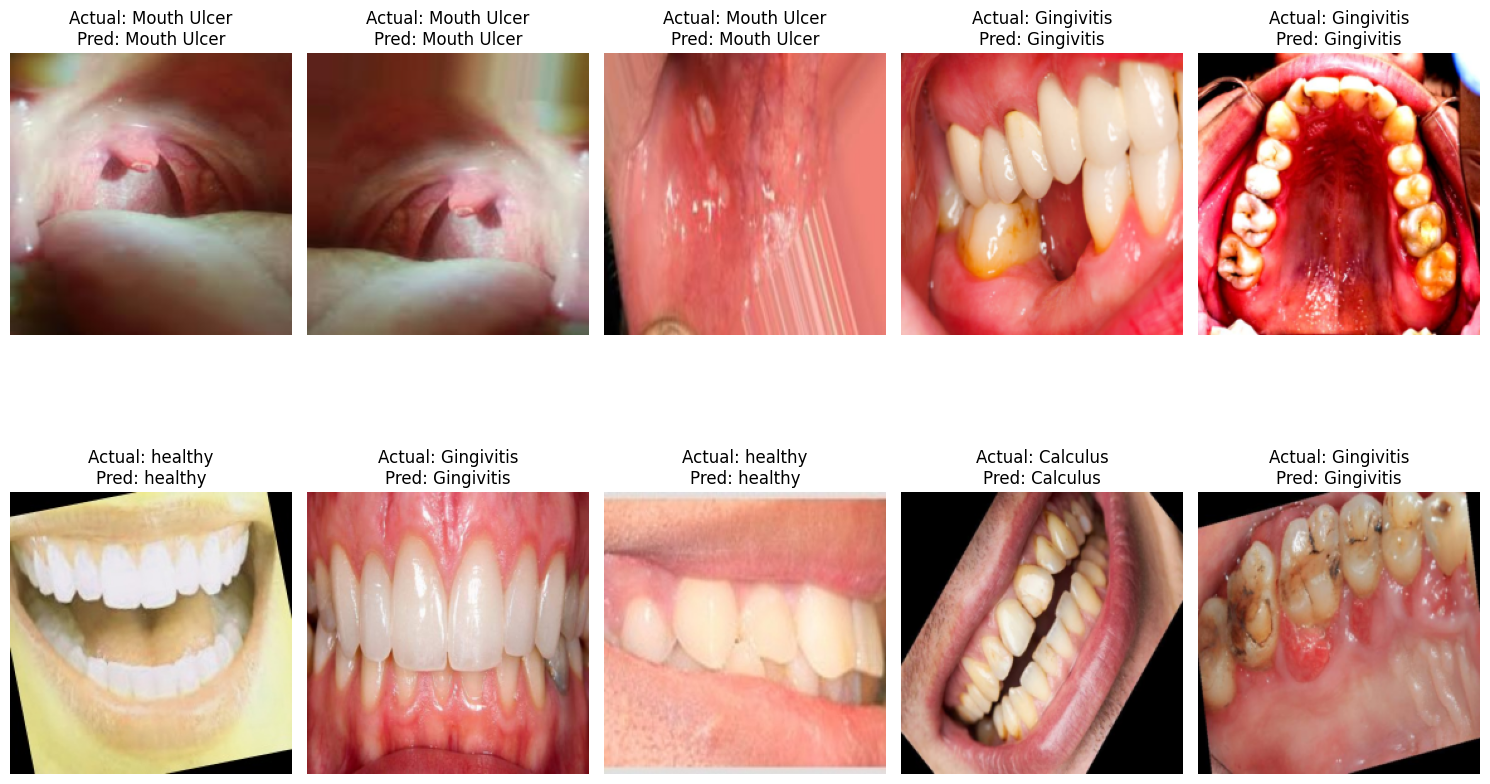

In [15]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
show_predictions(model, val_dataset, device, idx_to_class, num_images=10)

## Saving the model

In [16]:
torch.save(model, 'cnn_with_attention.pkl')